In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import os
import torch.utils.data as data
import torch.nn as nn
import glob
# from torchsummary import summary
from torchinfo import summary
from tqdm import trange

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:2")
print(device)
current_device = device #torch.cuda.current_device()
device_name = torch.cuda.get_device_name(current_device)
print(f"Current GPU assigned: {current_device}, Name: {device_name}")

cuda:2
Current GPU assigned: cuda:2, Name: NVIDIA A100-SXM4-80GB


Consider it a prediction task only, but for now, use only pressure and/or wind speed inputs to start with, because they are the indicators of horizontal movement of air pollution. Multiple inputs can go as multiple channels of images similar to RGB. Output should be only P25 for now. You can train on some 10 days of data and predict on next 10 days of data.

In [3]:
def get_latitudes():
    lat_start= 76.8499984741211
    lat_step=0.009999999776482582

    latitudes=[]

    for i in range(80):
        latitudes.append(lat_start+i*lat_step)
    
    latitudes.reverse()

    return latitudes

def get_longitudes():
    long_start= 28.200000762939453
    long_step=0.009999999776482582

    longitudes=[]

    for i in range(80):
        longitudes.append(long_start+i*long_step)
    
    # longitudes.reverse()

    return longitudes

latitudes=get_latitudes()
longitudes=get_longitudes()

def create_plot(data,hour,var_name):
    # print(data[var_name].shape) #shape (120, 1, 80, 80)
    p10_hour=data[var_name]['TSTEP'==hour] # shape (1, 80, 80)
    p10_hour=p10_hour[0,:,:] # shape (80, 80)
    plt.imshow(p10_hour)
    plt.title(f'{var_name} at hour '+str(hour))
    # plt.colorbar()

    # only show every latitude and longitude of end points
    # round to 2 decimal places
    top=latitudes[0]
    top=round(top,2) 
    bottom=latitudes[-1]
    bottom=round(bottom,2)
    left=longitudes[0]
    left=round(left,2)
    right=longitudes[-1]
    right=round(right,2)

    plt.xticks([0,79],[left,right])
    plt.xlabel('Longitude')
    plt.yticks([0,79],[top,bottom])
    plt.ylabel('Latitude')
    # plt.savefig(f'plots/120/{var_name}_{day}.png')
    # plt.close()

# 96 hr files

In [50]:
data_96 = xr.open_dataset('data/camxmet2d.delhi.20230717.96hours.nc')
data_96_df = data_96.to_dataframe().reset_index()

In [51]:
data_96

<xarray.Dataset>
Dimensions:     (TSTEP: 96, VAR: 14, DATE-TIME: 2, LAY: 1, ROW: 80, COL: 80)
Dimensions without coordinates: TSTEP, VAR, DATE-TIME, LAY, ROW, COL
Data variables: (12/15)
    TFLAG       (TSTEP, VAR, DATE-TIME) int32 2023198 0 ... 2023201 230000
    TSURF_K     (TSTEP, LAY, ROW, COL) float32 302.3 302.3 302.3 ... 300.6 301.2
    SNOWEW_M    (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SNOWAGE_HR  (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PRATE_MMpH  (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CLOUD_OD    (TSTEP, LAY, ROW, COL) float32 62.24 61.67 61.1 ... 37.1 36.78
    ...          ...
    SWSFC_WpM2  (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SOLM_M3pM3  (TSTEP, LAY, ROW, COL) float32 0.3131 0.3114 ... 0.3278 0.3292
    CLDTOP_KM   (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CAPE        (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PBL_WRF_M   (TSTEP, LAY, ROW, COL) float32 17.21 17.21 17.21 ... 94.4 120.0
    PBL_YSU_M   (TSTEP, LAY, ROW, COL) float32 17.21 17.21 17.21 ... 64.43 94.71
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023198
    CTIME:          73941
    WDATE:          2023198
    ...             ...
    VGLVLS:         [0. 0.]
    GDNAM:          ????????????????
    UPNAM:          CAMx2IOAPI      
    VAR-LIST:       TSURF_K         SNOWEW_M        SNOWAGE_HR      PRATE_MMp...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:

In [52]:
data_96_df

,TSTEP,VAR,DATE-TIME,LAY,ROW,COL,TFLAG,TSURF_K,SNOWEW_M,SNOWAGE_HR,...,CLOUD_OD,U10_MpS,V10_MpS,T2_K,SWSFC_WpM2,SOLM_M3pM3,CLDTOP_KM,CAPE,PBL_WRF_M,PBL_YSU_M
0,0,0,0,0,0,0,2023198,302.314636,0.0,0.0,...,62.239326,1.630373,0.148722,302.571838,0.0,0.313128,0.0,0.0,17.212452,17.212452
1,0,0,0,0,0,1,2023198,302.312042,0.0,0.0,...,61.671093,1.585281,0.158011,302.584351,0.0,0.311416,0.0,0.0,17.212652,17.212652
2,0,0,0,0,0,2,2023198,302.309479,0.0,0.0,...,61.102859,1.540188,0.167299,302.596832,0.0,0.309703,0.0,0.0,17.212852,17.212852
3,0,0,0,0,0,3,2023198,302.306885,0.0,0.0,...,60.534630,1.495095,0.176587,302.609344,0.0,0.307990,0.0,0.0,17.213055,17.213055
4,0,0,0,0,0,4,2023198,302.303558,0.0,0.0,...,59.912636,1.450304,0.184773,302.621948,0.0,0.306286,0.0,0.0,17.213356,17.213356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17203195,95,13,1,0,79,75,230000,298.979095,0.0,0.0,...,37.972748,0.600130,-1.341342,299.389465,0.0,0.324286,0.0,0.0,26.661556,17.082989
17203196,95,13,1,0,79,76,230000,299.372223,0.0,0.0,...,37.747482,0.658128,-1.301898,299.638062,0.0,0.324927,0.0,0.0,43.123440,17.094244
17203197,95,13,1,0,79,77,230000,299.967468,0.0,0.0,...,37.423786,0.732263,-1.252025,300.018402,0.0,0.326345,0.0,0.0,68.759804,17.112419
17203198,95,13,1,0,79,78,230000,300.562744,0.0,0.0,...,37.100090,0.806398,-1.202152,300.398743,0.0,0.327763,0.0,0.0,94.396065,64.426094


In [53]:
data_96_df.columns

Index(['TSTEP', 'VAR', 'DATE-TIME', 'LAY', 'ROW', 'COL', 'TFLAG', 'TSURF_K',
       'SNOWEW_M', 'SNOWAGE_HR', 'PRATE_MMpH', 'CLOUD_OD', 'U10_MpS',
       'V10_MpS', 'T2_K', 'SWSFC_WpM2', 'SOLM_M3pM3', 'CLDTOP_KM', 'CAPE',
       'PBL_WRF_M', 'PBL_YSU_M'],
      dtype='object')

In [56]:
data_96['U10_MpS'] #shape (96, 1, 80, 80)

<xarray.DataArray 'U10_MpS' (TSTEP: 96, LAY: 1, ROW: 80, COL: 80)>
array([[[[ 1.630373, ..., -0.434344],
         ...,
         [-0.544169, ..., -2.070899]]],


       ...,


       [[[ 0.569056, ...,  0.423629],
         ...,
         [ 0.774855, ...,  0.880477]]]], dtype=float32)
Dimensions without coordinates: TSTEP, LAY, ROW, COL
Attributes:
    long_name:  U10_MpS         
    units:      ppmV            
    var_desc:   VARIABLE U10_MpS                                             ...

In [57]:
data_96['U10_MpS'].shape , data_96['U10_MpS']['TSTEP'==0].shape, data_96['U10_MpS']['TSTEP'==0][0].shape

((96, 1, 80, 80), (1, 80, 80), (80, 80))

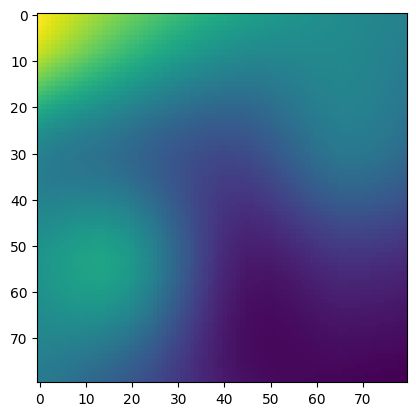

In [10]:
plt.imshow(data_96['U10_MpS']['TSTEP'==0][0]) #shape (80, 80)

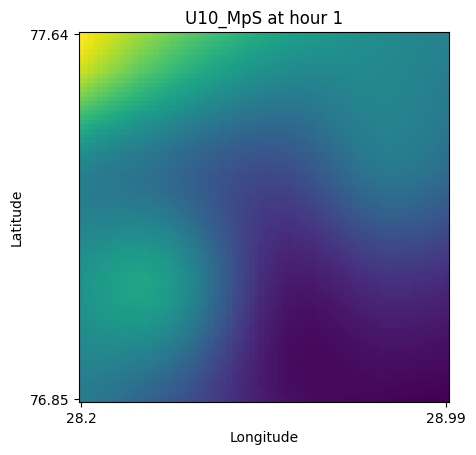

In [11]:
create_plot(data = data_96, hour = 1, var_name = 'U10_MpS')

# 120 hr files

In [12]:
data_120 = xr.open_dataset('data/camx120hr_merged_20230717.nc')
data_120_df = data_120.to_dataframe().reset_index() 

In [ ]:
data_120 

<xarray.Dataset>
Dimensions:  (TSTEP: 120, LAY: 1, ROW: 80, COL: 80, VAR: 9, DATE-TIME: 2)
Dimensions without coordinates: TSTEP, LAY, ROW, COL, VAR, DATE-TIME
Data variables:
    P10      (TSTEP, LAY, ROW, COL) float32 23.86 23.86 24.07 ... 10.1 10.1
    P25      (TSTEP, LAY, ROW, COL) float32 19.24 19.24 19.62 ... 9.63 9.63
    TFLAG    (TSTEP, VAR, DATE-TIME) int32 2023197 0 2023197 ... 2023201 230000
Attributes: (12/34)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023197
    CTIME:          83911
    WDATE:          2023197
    ...             ...
    GDNAM:          ????????????????
    UPNAM:          CAMXMETOU       
    VAR-LIST:       P10             P25             
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:        Mon Jul 17 08:45:22 2023: ncrcat camxout.2023.07.16.nc ca...
    NCO:            netCDF Operators version 4.9.1 (Homepage = http://nco.sf....

In [ ]:
data_120_df

,TSTEP,LAY,ROW,COL,VAR,DATE-TIME,P10,P25,TFLAG
0,0,0,0,0,0,0,23.857107,19.240587,2023197
1,0,0,0,0,0,1,23.857107,19.240587,0
2,0,0,0,0,1,0,23.857107,19.240587,2023197
3,0,0,0,0,1,1,23.857107,19.240587,0
4,0,0,0,0,2,0,23.857107,19.240587,2023197
...,...,...,...,...,...,...,...,...,...
13823995,119,0,79,79,6,1,10.097546,9.629862,230000
13823996,119,0,79,79,7,0,10.097546,9.629862,2023201
13823997,119,0,79,79,7,1,10.097546,9.629862,230000
13823998,119,0,79,79,8,0,10.097546,9.629862,2023201


In [ ]:
data_120_df.describe()

,TSTEP,LAY,ROW,COL,VAR,DATE-TIME,P10,P25,TFLAG
count,1.382400e+07,13824000.0,1.382400e+07,1.382400e+07,1.382400e+07,13824000.0,1.382400e+07,1.382400e+07,1.382400e+07
mean,5.950000e+01,0.0,3.950000e+01,3.950000e+01,4.000000e+00,0.5,4.101470e+01,2.856279e+01,1.069100e+06
std,3.463981e+01,0.0,2.309221e+01,2.309221e+01,2.581989e+00,0.5,2.361775e+01,1.582030e+01,9.553543e+05
min,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.111396e+00,8.114247e-01,0.000000e+00
25%,2.975000e+01,0.0,1.975000e+01,1.975000e+01,2.000000e+00,0.0,2.546643e+01,1.880392e+01,1.175000e+05
50%,5.950000e+01,0.0,3.950000e+01,3.950000e+01,4.000000e+00,0.5,3.590978e+01,2.589731e+01,1.126598e+06
75%,8.925000e+01,0.0,5.925000e+01,5.925000e+01,6.000000e+00,1.0,5.103806e+01,3.433007e+01,2.023199e+06
max,1.190000e+02,0.0,7.900000e+01,7.900000e+01,8.000000e+00,1.0,6.492913e+02,6.130998e+02,2.023201e+06


In [ ]:
data_120['COL']

<xarray.DataArray 'COL' (COL: 80)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79])
Dimensions without coordinates: COL

In [ ]:
data_120['P10'] #shape (120, 1, 80, 80)

<xarray.DataArray 'P10' (TSTEP: 120, LAY: 1, ROW: 80, COL: 80)>
array([[[[23.857107, ..., 28.82367 ],
         ...,
         [34.902046, ..., 18.506985]]],


       ...,


       [[[38.434433, ..., 22.536842],
         ...,
         [20.921093, ..., 10.097546]]]], dtype=float32)
Dimensions without coordinates: TSTEP, LAY, ROW, COL
Attributes:
    long_name:  CPRM            
    units:      micrograms/m**3 
    var_desc:   VARIABLE CPRM                                                ...

In [ ]:
data_120['P10']['TSTEP'==1]# shape 1x80x80

<xarray.DataArray 'P10' (LAY: 1, ROW: 80, COL: 80)>
array([[[23.857107, 23.857107, ..., 28.82367 , 28.82367 ],
        [23.857107, 23.857107, ..., 28.82367 , 28.82367 ],
        ...,
        [34.902046, 34.902046, ..., 18.506985, 18.506985],
        [34.902046, 34.902046, ..., 18.506985, 18.506985]]], dtype=float32)
Dimensions without coordinates: LAY, ROW, COL
Attributes:
    long_name:  CPRM            
    units:      micrograms/m**3 
    var_desc:   VARIABLE CPRM                                                ...

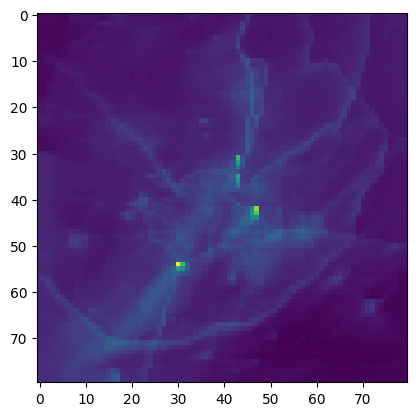

In [ ]:
data_120['P10']['TSTEP'==1][0] # shape 80x80
plt.imshow(data_120['P25']['TSTEP'==1][0])#, vmin=0, vmax=100)

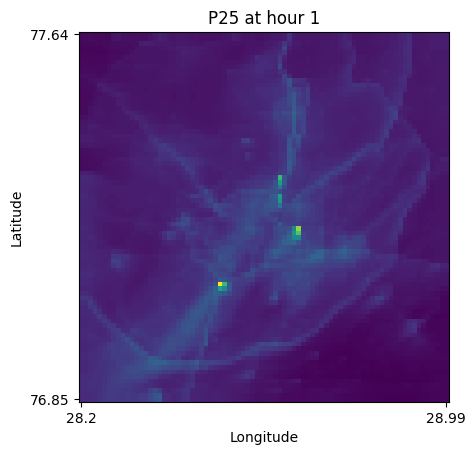

In [ ]:
create_plot(data_120,1,'P25') 

# Constructing data

In [4]:
# Define the folder path where your files are located
folder_path = 'data/'

# Use glob to retrieve all netCDF files in the folder
file_pattern = 'camx120*.nc'
files_120 = glob.glob(folder_path + file_pattern)
# files_120

file_pattern = '*96hours.nc'
files_96 = glob.glob(folder_path + file_pattern)
# files_96

In [5]:
print(len(files_120))
files_120.sort()
print(files_120[0], files_120[-1]) 

70
data/camx120hr_merged_20230717.nc data/camx120hr_merged_20230924.nc


In [6]:
print(len(files_96))
files_96.sort()
print(files_96[0], files_96[-1]) 

69
data/camxmet2d.delhi.20230717.96hours.nc data/camxmet2d.delhi.20230924.96hours.nc


camx96hr has 20230808 day file missing. so removing it from camx120hr as well 'data/camx120hr_merged_20230808.nc'

In [7]:
files_120.remove('data/camx120hr_merged_20230808.nc')
len(files_120)

69

camx96hr file contains 96 hrs for days [0,1,2,3]

camx120hr file contains 120 hrs for days [-1,0,1,2,3]

We need current day data from each file to avoid redundancy. So we will take 0-23 hrs from camx96hr and 24-47hrs from camx120hr

In [8]:
def get_data(target_var_96_list, target_var_120_list):
    X = []
    y = []
 
    for target_var_96 in target_var_96_list:
        column = []
        for i in files_96:
            data_96 = xr.open_dataset(i)
            for j in range(0,24):
                variable96 = data_96[target_var_96]['TSTEP'==j]
                column.append(variable96)
        column = np.array(column)
        # print(column.shape) # (69*24, 1, 80, 80)
        X.append(column)
    X = np.array(X)
    X = np.concatenate([X[i] for i in range(X.shape[0])], axis=1)
    print('X shape ',X.shape)
    for target_var_120 in target_var_120_list:
        column = []
        for i in files_120:
            data_120 = xr.open_dataset(i)
            for j in range(0,24):
                variable120 = data_120[target_var_120]['TSTEP'==24+j]
                column.append(variable120)
        column = np.array(column)
        # print(column.shape) # (69*24, 1, 80, 80)
        y.append(column)
    y = np.array(y)
    y = np.concatenate([y[i] for i in range(y.shape[0])], axis=1)
    print('y shape', y.shape)
    return X,y

In [9]:
target_var_96_list =['TSURF_K',
       'SNOWEW_M', 'SNOWAGE_HR', 'PRATE_MMpH', 'CLOUD_OD', 'U10_MpS',
       'V10_MpS', 'T2_K', 'SWSFC_WpM2', 'SOLM_M3pM3', 'CLDTOP_KM', 'CAPE',
       'PBL_WRF_M', 'PBL_YSU_M']  # ['U10_MpS', 'T2_K', 'V10_MpS']
target_var_120_list = ['P25','P10'] 
X,y  = get_data(target_var_96_list, target_var_120_list)

X shape  (1656, 14, 80, 80)
y shape (1656, 2, 80, 80)


In [30]:
X[:, 0, :,:].shape # selecting first channel

(1656, 80, 80)

# model defination

## Simple autoencoder

In [10]:
class Autoencoder_MLP(nn.Module):
    def __init__(self):
        super(Autoencoder_MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()  # Flatten the 2D input matrix
        self.fc1 = nn.Linear(80*80, 1024)  # Fully connected layer 1
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1024)  # Fully connected layer 2
        self.fc4 = nn.Linear(1024, 80*80)  # Fully connected layer 2
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        # Flatten the input
        x = self.flatten(x)
        
        # Forward pass through the fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)

        # Reshape the output to match the 2D matrix size
        x = x.view(-1, 80, 80)
        
        return x

In [11]:
summary(Autoencoder_MLP(), input_size=(1, 80, 80))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_MLP                          [1, 80, 80]               --
├─Flatten: 1-1                           [1, 6400]                 --
├─Linear: 1-2                            [1, 1024]                 6,554,624
├─ReLU: 1-3                              [1, 1024]                 --
├─Linear: 1-4                            [1, 512]                  524,800
├─ReLU: 1-5                              [1, 512]                  --
├─Linear: 1-6                            [1, 1024]                 525,312
├─ReLU: 1-7                              [1, 1024]                 --
├─Linear: 1-8                            [1, 6400]                 6,560,000
Total params: 14,164,736
Trainable params: 14,164,736
Non-trainable params: 0
Total mult-adds (M): 14.16
Input size (MB): 0.03
Forward/backward pass size (MB): 0.07
Params size (MB): 56.66
Estimated Total Size (MB): 56.76

In [12]:
class CustomDataset(data.Dataset):
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_sample = torch.Tensor(self.input_data[index])
        output_sample = torch.Tensor(self.output_data[index])
        return input_sample, output_sample 

# training

In [13]:
test_days = 5 # 5 days as test data
X_train_all = X[:-24*test_days]
X_test_all = X[-24*test_days:]
y_train_all = y[:-24*test_days]
y_test_all = y[-24*test_days:] 
X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape    

((1536, 14, 80, 80), (120, 14, 80, 80), (1536, 2, 80, 80), (120, 2, 80, 80))

X Channel name :  TSURF_K
Shapes:  (1536, 80, 80) (120, 80, 80) (1536, 80, 80) (120, 80, 80)


Epoch [1/100] Loss: 400.9971
Epoch [21/100] Loss: 209.2517
Epoch [41/100] Loss: 211.5168
Epoch [61/100] Loss: 211.2578
Epoch [81/100] Loss: 208.6892
Average Test Loss: 155.8108


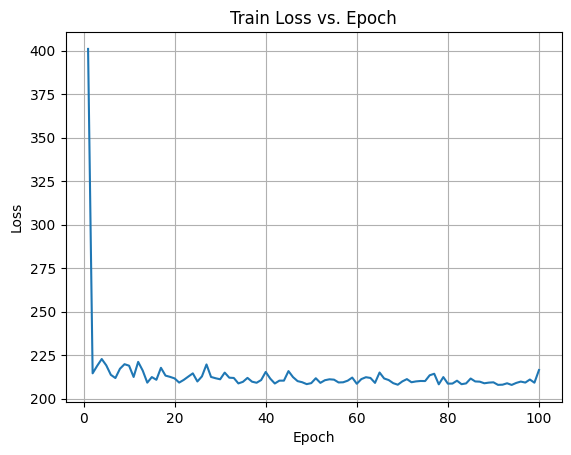

X Channel name :  SNOWEW_M
Shapes:  (1536, 80, 80) (120, 80, 80) (1536, 80, 80) (120, 80, 80)
Epoch [1/100] Loss: 419.8964
Epoch [21/100] Loss: 208.5981
Epoch [41/100] Loss: 209.8300
Epoch [61/100] Loss: 208.4564
Epoch [81/100] Loss: 210.5506
Average Test Loss: 160.1894


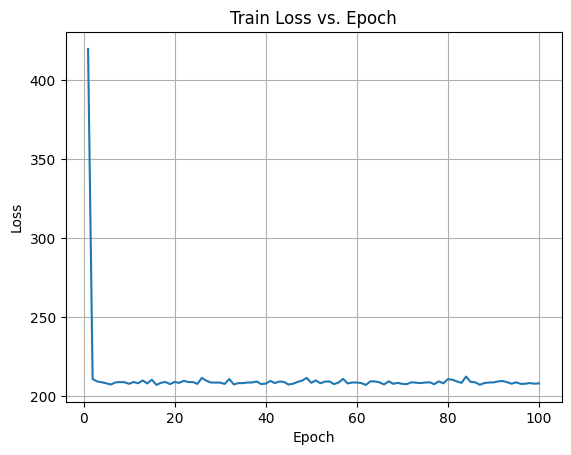

X Channel name :  SNOWAGE_HR
Shapes:  (1536, 80, 80) (120, 80, 80) (1536, 80, 80) (120, 80, 80)
Epoch [1/100] Loss: 423.6197
Epoch [21/100] Loss: 211.4255
Epoch [41/100] Loss: 208.5194
Epoch [61/100] Loss: 209.5715
Epoch [81/100] Loss: 207.6051
Average Test Loss: 134.2696


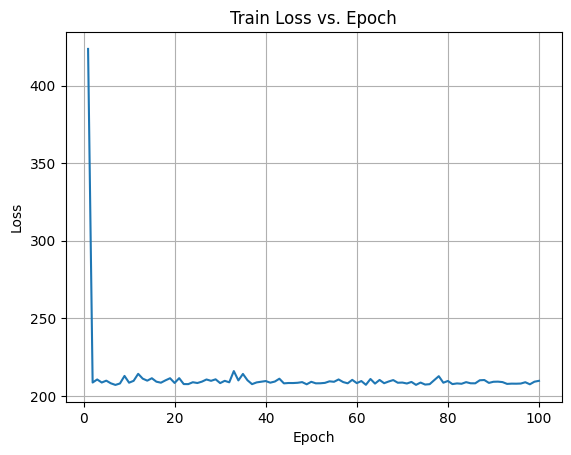

X Channel name :  PRATE_MMpH
Shapes:  (1536, 80, 80) (120, 80, 80) (1536, 80, 80) (120, 80, 80)
Epoch [1/100] Loss: 418.2835
Epoch [21/100] Loss: 210.2482
Epoch [41/100] Loss: 207.4567
Epoch [61/100] Loss: 209.2682
Epoch [81/100] Loss: 208.6846
Average Test Loss: 140.0742


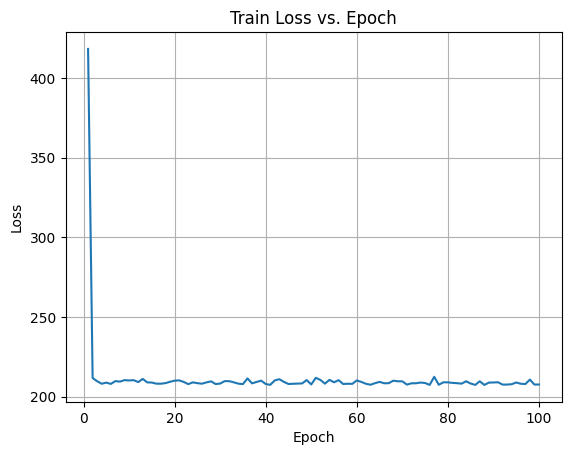

X Channel name :  CLOUD_OD
Shapes:  (1536, 80, 80) (120, 80, 80) (1536, 80, 80) (120, 80, 80)
Epoch [1/100] Loss: 545.9154
Epoch [21/100] Loss: 177.7056
Epoch [41/100] Loss: 41.5926
Epoch [61/100] Loss: 14.0680
Epoch [81/100] Loss: 20.0998
Average Test Loss: 806.8964


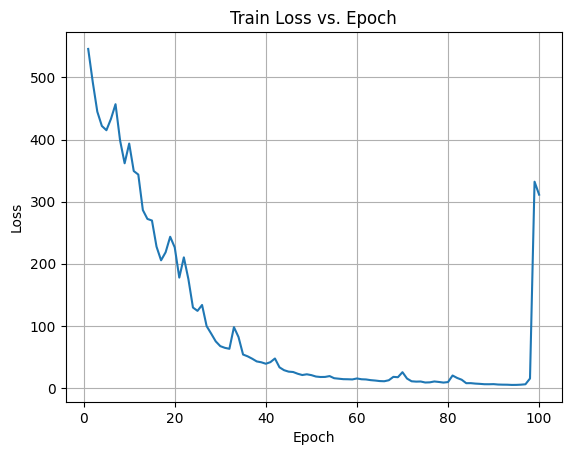

X Channel name :  U10_MpS
Shapes:  (1536, 80, 80) (120, 80, 80) (1536, 80, 80) (120, 80, 80)
Epoch [1/100] Loss: 370.8361
Epoch [21/100] Loss: 46.5412
Epoch [41/100] Loss: 20.2286
Epoch [61/100] Loss: 20.3918
Epoch [81/100] Loss: 0.3426
Average Test Loss: 620.2401


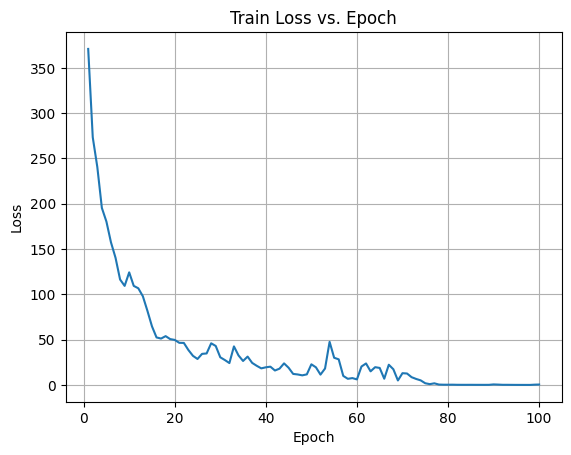

X Channel name :  V10_MpS
Shapes:  (1536, 80, 80) (120, 80, 80) (1536, 80, 80) (120, 80, 80)
Epoch [1/100] Loss: 375.2369
Epoch [21/100] Loss: 0.2244
Epoch [41/100] Loss: 1.8484
Epoch [61/100] Loss: 1.0851
Epoch [81/100] Loss: 0.0682
Average Test Loss: 234.4134


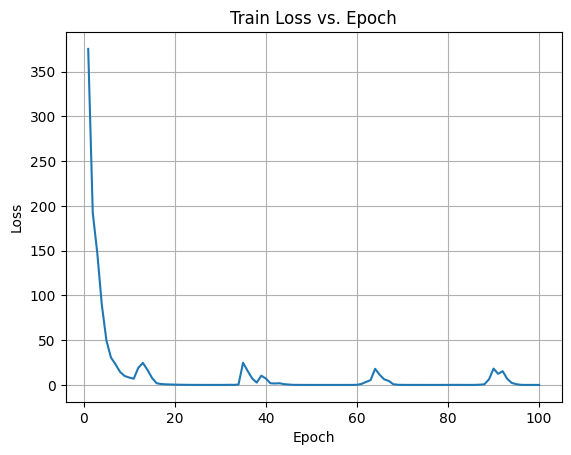

X Channel name :  T2_K
Shapes:  (1536, 80, 80) (120, 80, 80) (1536, 80, 80) (120, 80, 80)
Epoch [1/100] Loss: 390.7466
Epoch [21/100] Loss: 210.7569
Epoch [41/100] Loss: 213.5745
Epoch [61/100] Loss: 210.2519
Epoch [81/100] Loss: 209.4803
Average Test Loss: 119.1715


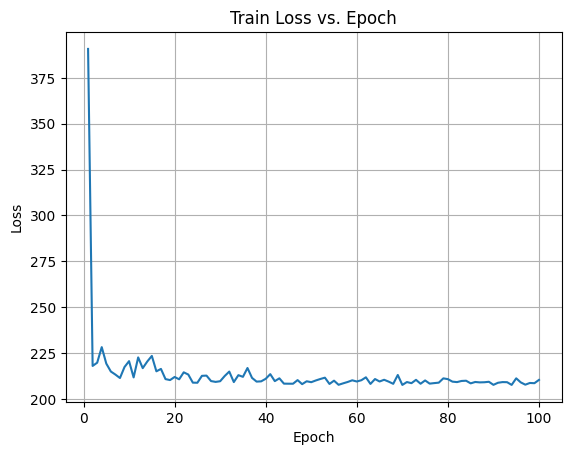

X Channel name :  SWSFC_WpM2
Shapes:  (1536, 80, 80) (120, 80, 80) (1536, 80, 80) (120, 80, 80)
Epoch [1/100] Loss: 430.2450
Epoch [21/100] Loss: 212.3692
Epoch [41/100] Loss: 207.7206
Epoch [61/100] Loss: 208.6094
Epoch [81/100] Loss: 208.9528
Average Test Loss: 152.6968


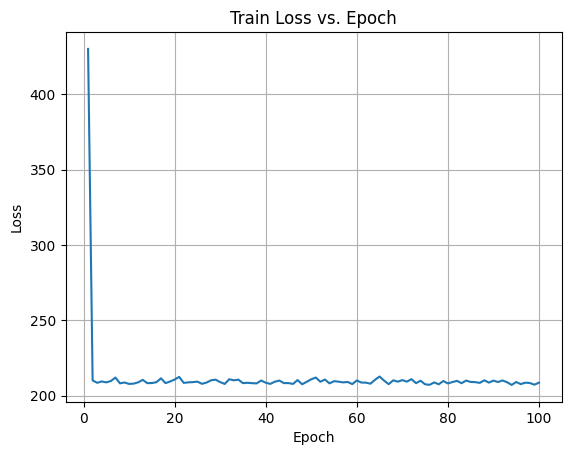

X Channel name :  SOLM_M3pM3
Shapes:  (1536, 80, 80) (120, 80, 80) (1536, 80, 80) (120, 80, 80)
Epoch [1/100] Loss: 292.8980
Epoch [21/100] Loss: 168.8671
Epoch [41/100] Loss: 161.6821
Epoch [61/100] Loss: 148.2756
Epoch [81/100] Loss: 141.9474
Average Test Loss: 169.5534


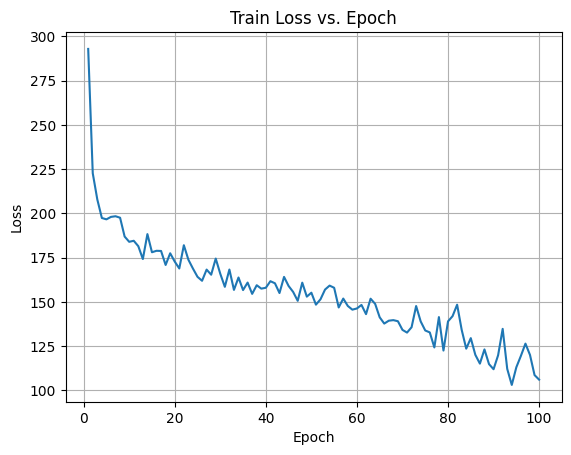

X Channel name :  CLDTOP_KM
Shapes:  (1536, 80, 80) (120, 80, 80) (1536, 80, 80) (120, 80, 80)
Epoch [1/100] Loss: 427.2160
Epoch [21/100] Loss: 211.5536
Epoch [41/100] Loss: 209.0157
Epoch [61/100] Loss: 209.4848
Epoch [81/100] Loss: 208.0533
Average Test Loss: 172.1217


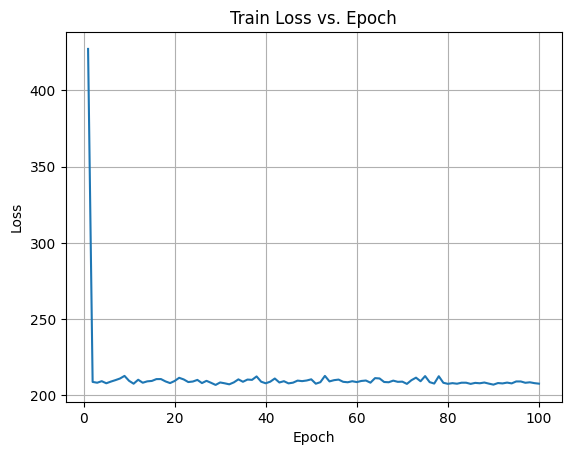

X Channel name :  CAPE
Shapes:  (1536, 80, 80) (120, 80, 80) (1536, 80, 80) (120, 80, 80)
Epoch [1/100] Loss: 425.4291
Epoch [21/100] Loss: 209.3390
Epoch [41/100] Loss: 210.4041
Epoch [61/100] Loss: 207.7122
Epoch [81/100] Loss: 208.3262
Average Test Loss: 156.2082


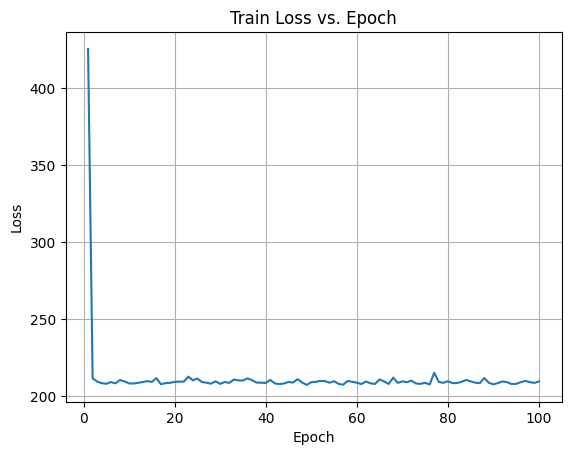

X Channel name :  PBL_WRF_M
Shapes:  (1536, 80, 80) (120, 80, 80) (1536, 80, 80) (120, 80, 80)
Epoch [1/100] Loss: 272.3727
Epoch [21/100] Loss: 209.6681
Epoch [41/100] Loss: 209.1327
Epoch [61/100] Loss: 209.0138
Epoch [81/100] Loss: 207.7615
Average Test Loss: 149.8876


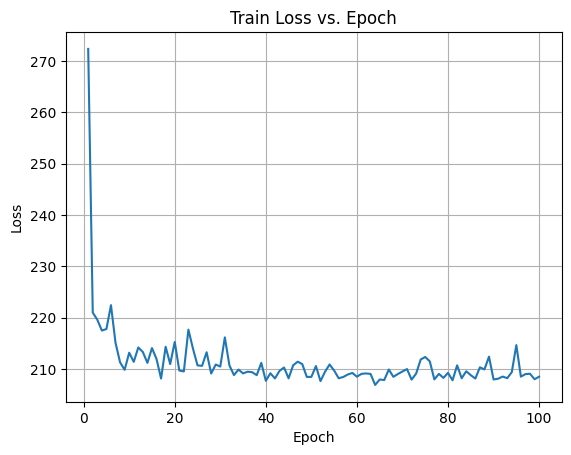

X Channel name :  PBL_YSU_M
Shapes:  (1536, 80, 80) (120, 80, 80) (1536, 80, 80) (120, 80, 80)
Epoch [1/100] Loss: 264.0474
Epoch [21/100] Loss: 210.0482
Epoch [41/100] Loss: 209.2329
Epoch [61/100] Loss: 208.8669
Epoch [81/100] Loss: 207.9824
Average Test Loss: 169.9573


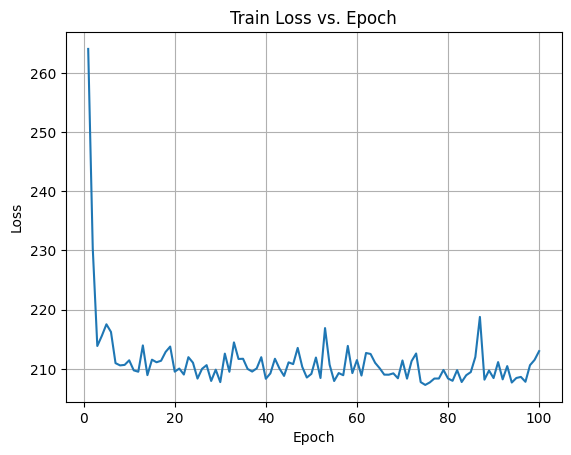

In [15]:
test_loss_list_P_25 = []
y_channel = 0 
# x_channel = 0
for x_channel in range(X.shape[1]):
    ####################### Selecting the channel #######################
    print('X Channel name : ', target_var_96_list[x_channel])
    X_train = X_train_all[:, x_channel, :,:]
    X_test = X_test_all[:, x_channel, :,:]
    y_train = y_train_all[:, y_channel, :,:]
    y_test = y_test_all[:, y_channel, :,:]
    print('Shapes: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    ####################### Creating the dataset loader #######################
    train_custom_dataset = CustomDataset(X_train, y_train)
    # print(len(train_custom_dataset))
    batch_size = 32
    train_loader = data.DataLoader(train_custom_dataset, batch_size=batch_size, shuffle=True)
    # print(len(train_loader))
    
    test_custom_dataset = CustomDataset(X_test, y_test)
    # print(len(test_custom_dataset))
    batch_size = 32
    test_loader = data.DataLoader(test_custom_dataset, batch_size=batch_size, shuffle=False)
    # print(len(test_loader))
    

    #################### Training the model ####################
    model = Autoencoder_MLP()
    model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    # Training loop
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        # Print the average loss for this epoch
        average_loss = total_loss / len(train_loader)
        losses.append(average_loss)
        if epoch % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {average_loss:.4f}")
    
    
    ############################# testing the model #############################
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, targets)

            test_loss += loss.item()

    # Print the average test loss
    average_test_loss = test_loss / len(test_loader)
    test_loss_list_P_25.append(average_test_loss)
    print(f"Average Test Loss: {average_test_loss:.4f}")
    
    plt.plot(range(1, num_epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss vs. Epoch for channel '+target_var_96_list[x_channel])
    plt.grid(True) 
    plt.show() 

In [16]:
target_var_96_list

['TSURF_K',
 'SNOWEW_M',
 'SNOWAGE_HR',
 'PRATE_MMpH',
 'CLOUD_OD',
 'U10_MpS',
 'V10_MpS',
 'T2_K',
 'SWSFC_WpM2',
 'SOLM_M3pM3',
 'CLDTOP_KM',
 'CAPE',
 'PBL_WRF_M',
 'PBL_YSU_M']

In [17]:
test_loss_list_P_25

[155.8108196258545,
 160.18942546844482,
 134.26961517333984,
 140.07422065734863,
 806.8964252471924,
 620.2400703430176,
 234.41343688964844,
 119.17151355743408,
 152.69680213928223,
 169.55335426330566,
 172.1217212677002,
 156.2082118988037,
 149.8876371383667,
 169.95728302001953]

In [19]:
name_loss_pairs = list(zip(target_var_96_list, test_loss_list_P_25))

# Sort based on loss values
sorted_name_loss_pairs = sorted(name_loss_pairs, key=lambda x: x[1])

# Select the lowest 3 names
lowest_3_names = [pair[0] for pair in sorted_name_loss_pairs[:3]]

print("Lowest 3 names:", lowest_3_names)

Lowest 3 names: ['T2_K', 'SNOWAGE_HR', 'PRATE_MMpH']
